In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Visualization Testing

In [3]:
# FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
action = ''
RUNTIME=2.0

In [4]:
name = f"sarfa_baseline_{int(RUNTIME * 10)}"
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = BoardVisualization(board)


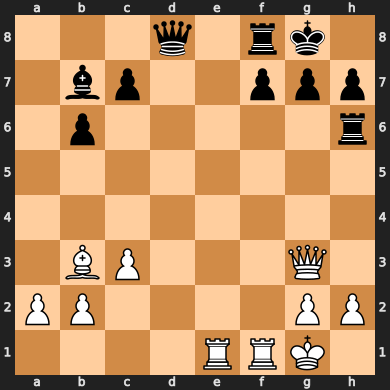

In [5]:
board_visualization.only_board()

# Sarfa (without defined action)

In [9]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency}")

a2 removed: 0.6100578956497222
b2 removed: 0.08022940198152823
b3 removed: 0.6992049337797575
b6 removed: 0.024756890499496146
b7 removed: 0.6697639488396626
c3 removed: 0.9884999369706191
c7 removed: 0.8227794204402822
d8 removed: 0
e1 removed: 0.7045135973351921
f1 removed: 0.34333305117157664
f7 removed: 0
f8 removed: 0.08385650161885373


KeyboardInterrupt: 

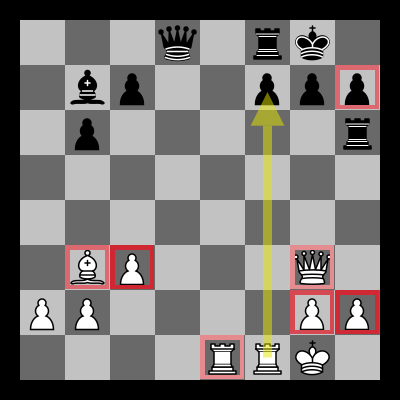

In [ ]:
path = board_visualization.show_heatmap(saliency_results, chess.Move.from_uci(sarfa_compute_result.optimal_move))
display(Image(path))

# Sarfa Baseline with Move

In [38]:
board = chess.Board("3q2k1/1bp2rpp/1p5r/8/8/1BP3Q1/PP4PP/4R1K1 w - - 0 2")
board_visualization = BoardVisualization(board)
action: chess.Move = chess.Move.from_uci("g3c7")

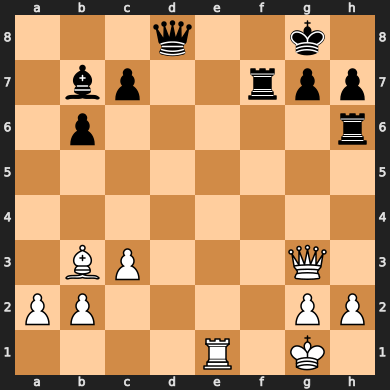

In [39]:
board_visualization.only_board()

In [50]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board, runtime=2)
for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, action)
    saliency_results[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency} \t {sarfa_compute_result}")
    if perturbed_position_str == "g7":
        break


a2 removed: 0.008150802185373542 	 SarfaComputeResult(saliency=0.008150802185373542, dP=0.004095268924691808, optimal_move='g3c7')
b2 removed: 0.01199321443876336 	 SarfaComputeResult(saliency=0.01199321443876336, dP=0.006039984828897116, optimal_move='g3c7')
b3 removed: 0.6240180011675001 	 SarfaComputeResult(saliency=0.6240180011675001, dP=0.9626462007392401, optimal_move='g3c7')
b6 removed: 0 	 SarfaComputeResult(saliency=0, dP=-0.0030254044855114737, optimal_move='g3c7')
b7 removed: 0 	 SarfaComputeResult(saliency=0, dP=-0.004985722749081267, optimal_move='g3c7')
c3 removed: 0.8293053136405594 	 SarfaComputeResult(saliency=0.8293053136405594, dP=0.9665829753023653, optimal_move='g3c7')
c7 removed: 0.04184793712508797 	 SarfaComputeResult(saliency=0.04184793712508797, dP=0.02212900345651958, optimal_move='g3c7')
d8 removed: 0.05347946511772906 	 SarfaComputeResult(saliency=0.05347946511772906, dP=0.6616809439175828, optimal_move='g3c7')
e1 removed: 0.637885693817202 	 SarfaComputeRe

In [51]:
perturbed_board.was_into_check()

True

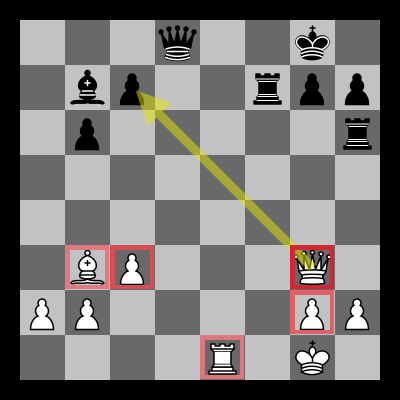

In [52]:
path = board_visualization.show_heatmap(saliency_results, action)
display(Image(path))

# Benchmarking

In [6]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


In [8]:
benchmark = SafraBenchmark.run(saliency_algorithm, name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1
R4rk1/5bb1/1N1Qpq1p/3pn1p1/3N4/2P2P1P/P5P1/5B1K w - - 0 1
5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1


In [23]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7902174632702069}

# Loading

In [24]:
sarfa_benchmark = SafraBenchmark.load_results(saliency_algorithm, "sarfa_baseline_20")

In [25]:
sarfa_benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7993333176970103}

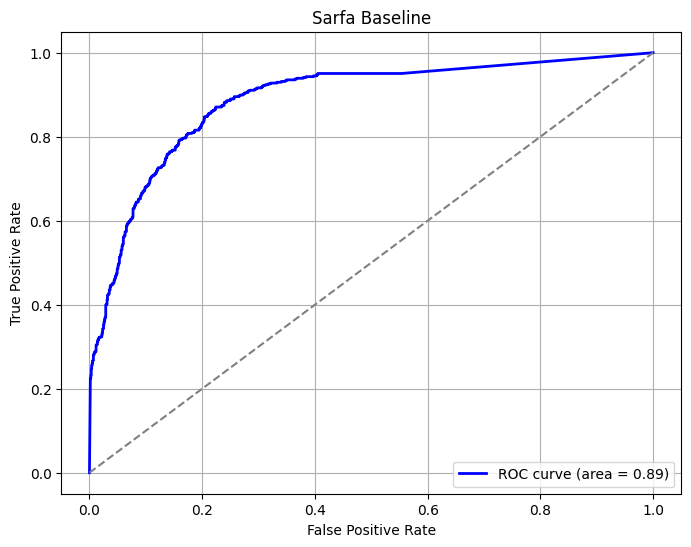

In [26]:
sarfa_benchmark.plot_roc("Sarfa Baseline")

In [22]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)

board_visualizer = BoardVisualization(board)

legal_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(chess.Board(FEN), legal_moves, multipv=len(legal_moves), runtime=2.0)

saliency_results = saliency_algorithm(FEN)


board_visualizer.show_heatmap(saliency_results, chess.Move.from_uci(optimal_move))

'svg_custom/board.png'

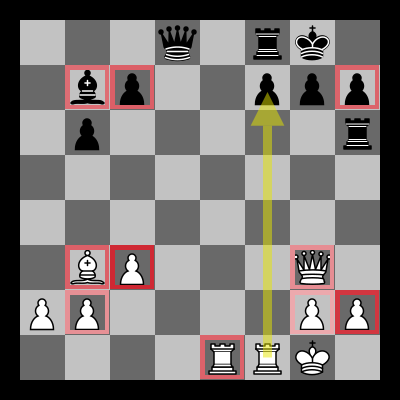

In [23]:
display(Image('svg_custom/board.png'))